In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from prnn.analysis.TuningCurveAnalysis import TuningCurveAnalysis
from prnn.utils.predictiveNet import PredictiveNet
import numpy as np
import matplotlib.pyplot as plt

import itertools
import pandas as pd


/home/mila/a/aleksei.efremov/pRNN/prnn/utils/predictiveNet.py:441: DeprecationWarning: invalid escape sequence \{
  print(f"loss: {steploss:>.2}, sparsity: {sparsity:>.2}, meanrate: {meanrate:>.2} [{bb:>5d}\{num_trials:>5d}]")
/home/mila/a/aleksei.efremov/pRNN/prnn/utils/predictiveNet.py:468: DeprecationWarning: invalid escape sequence \{
  print(f"loss: {steploss:>.2}, sparsity: {sparsity:>.2}, meanrate: {meanrate:>.2} [{bb:>5d}\{num_trials:>5d}]")


In [3]:
savefolder = 'Figures/20250430_Grid_LogNOrthogonalization/'

In [4]:
nettypes = ['thRNN_5win','lognRNN_mask']
# kvalues = ['2']
# hpidx = ['0','1','2','3','4']
seeds = ['42', '1042', '2042', '3042', '4042', '5042', '6042', '7042', '8042', '9042']
actenc = ['ContSpeedOnehotHD']

netprops = itertools.product(*[nettypes,['-'],actenc,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netcontext = [name[3] for name in netprops]
netseed = [int(name[4]) for name in netprops]
#netdirect = [name[2] for name in netprops]

netFolder = '/home/mila/a/aleksei.efremov/pRNN/' #Abs path
netsubfolder = 'example_net_RiaB_grid_batch8/'

analysisFrame = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'seed':netseed, 
                                        'netfolder':netFolder, 'netsubfolder':netsubfolder})

In [5]:
def loadNet(row):
    try:
        net = PredictiveNet.loadNet(row['netsubfolder']+row['filename'],savefolder = row['netfolder'], suppressText=True)
        return net
    except:
        print(f"{row['filename']} does not exist")
        #net = PredictiveNet
        net = None
        return net

#analysisFrame['net'] = analysisFrame.apply(loadNet, axis = 1)

In [6]:
def getHparms(row):
    predictiveNet = loadNet(row)
    if predictiveNet is None:
        return
    parms = {
        'mean_std_ratio' : predictiveNet.trainArgs.mean_std_ratio,
        'sparsity' : predictiveNet.trainArgs.sparsity,
        'NNeurons' : predictiveNet.trainArgs.hiddensize,
        'eg_weight_decay' : predictiveNet.trainArgs.eg_weight_decay,
        'eg_lr' : predictiveNet.trainArgs.eg_lr,
        }

    return pd.Series(parms)

hparms = analysisFrame.apply(getHparms, axis = 1)
analysisFrame = analysisFrame.join(hparms)
analysisFrame = analysisFrame.dropna()

#max_msr = analysisFrame['mean_std_ratio'].max()
#analysisFrame['mean_std_ratio'][analysisFrame['type']=='thcycRNN_5win_full']=max_msr*10


In [7]:
def getPredPerformance(row):
    #predictiveNet = row['net']
    predictiveNet = loadNet(row)
    try:
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    except:
        try:
            finalLoss = predictiveNet.TrainingSaver['loss']
        except:
            finalLoss = predictiveNet.TrainingSaver.transpose()['loss']
        
    
    return finalLoss 

analysisFrame['finalLoss'] = analysisFrame.apply(getPredPerformance, axis = 1)

In [8]:
#Calculate spatial info and decoding performance
def getSpatialRep(row):
    predictiveNet = loadNet(row)
    #print(len(predictiveNet.TrainingSaver['sRSA'].values))
    numepochs = len(predictiveNet.TrainingSaver['sRSA'].values)
    try:
        SI = predictiveNet.TrainingSaver['SI'].values[-1]
        sRSA = predictiveNet.TrainingSaver['sRSA'].values[-1]

        EVs = predictiveNet.TrainingSaver['EVs'].values[-1]
        
        SWdist = predictiveNet.TrainingSaver['SWdist'].values[-1]
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    except:
        try:
            SI = predictiveNet.TrainingSaver['SI']
            sRSA = predictiveNet.TrainingSaver['sRSA']

            EVs = predictiveNet.TrainingSaver['EVs']

            SWdist = predictiveNet.TrainingSaver['SWdist']
            finalLoss = predictiveNet.TrainingSaver['loss']
        except:
            SI = predictiveNet.TrainingSaver.transpose()['SI'].values[-1]
            sRSA = predictiveNet.TrainingSaver.transpose()['sRSA'].values[-1]

            EVs = predictiveNet.TrainingSaver.transpose()['EVs'].values[-1]

            SWdist = predictiveNet.TrainingSaver.transpose()['SWdist'].values[-1]
            finalLoss = predictiveNet.TrainingSaver.transpose()['loss'].values[-1]
    
    meanSI = np.nanmean(SI)
    EVsp50 = np.nanmean(EVs>0.5)
    tunedSI = np.nanmean(SI[EVs>0.5])

    # pUntuned = predictiveNet.TrainingSaver['celltype_Fraction'].values[0][0]
    # #NOTE: this should be changed to call the index for single field cells from cell type names...
    # pSingleField = predictiveNet.TrainingSaver['celltype_Fraction'].values[0][3]
    # pSingleField = pSingleField / (1-np.sum(predictiveNet.TrainingSaver['celltype_Fraction'].values[0][0:2]))
    
    # dh0 = predictiveNet.TrainingSaver['dh0'].values[0]
    # dhInf = predictiveNet.TrainingSaver['dhInf'].values[0]
    # dx_half = predictiveNet.TrainingSaver['dx_half'].values[0]

    return (SI, meanSI, sRSA, EVs, EVsp50, finalLoss, SWdist, tunedSI, numepochs, 
            # pUntuned, pSingleField, dh0, dhInf, dx_half
            )
            
analysisFrame[['SI','meanSI','sRSA','EVs','EVs50','finalLoss',
                'SWdist','tunedSI','numepochs',
                # 'pUntuned','pSingleField',
                # 'dh0','dhInf','dx_half'
                ]] = analysisFrame.apply(getSpatialRep, axis = 1, result_type="expand")


In [9]:
exseed = 42 #(13 good)
compareFrame = analysisFrame[analysisFrame['seed']==exseed]
compareFrame
predictiveNet_uniform = loadNet(compareFrame.loc[0])
predictiveNet_logN = loadNet(compareFrame.loc[10])
#compareFrame
compareFrame

,filename,type,seed,netfolder,netsubfolder,mean_std_ratio,sparsity,NNeurons,eg_weight_decay,eg_lr,finalLoss,SI,meanSI,sRSA,EVs,EVs50,SWdist,tunedSI,numepochs
0,thRNN_5win-ContSpeedOnehotHD-s42,thRNN_5win,42,/home/mila/a/aleksei.efremov/pRNN/,example_net_RiaB_grid_batch8/,1.0,0.1,500.0,1.000000e-08,0.002,0.003336,"[1.6916569547454663, 1.2657846967369824, 1.487...",1.240971,0.47529,"[0.551574, 0.19637829, -0.12331247, 0.23335582...",0.080,0.117659,2.108383,61441
10,lognRNN_mask-ContSpeedOnehotHD-s42,lognRNN_mask,42,/home/mila/a/aleksei.efremov/pRNN/,example_net_RiaB_grid_batch8/,1.0,0.1,500.0,1.000000e-08,0.002,0.008554,"[1.916325176653441, 0.8734350062005038, 1.0768...",1.312966,0.66119,"[0.5731811, 0.3732745, 0.22128129, 0.59554005,...",0.208,0.055371,1.575529,61441


thRNN_5win-ContSpeedOnehotHD-s42
Calculating EV_s
Running WAKE


/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/TuningCurveAnalysis.py:513: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


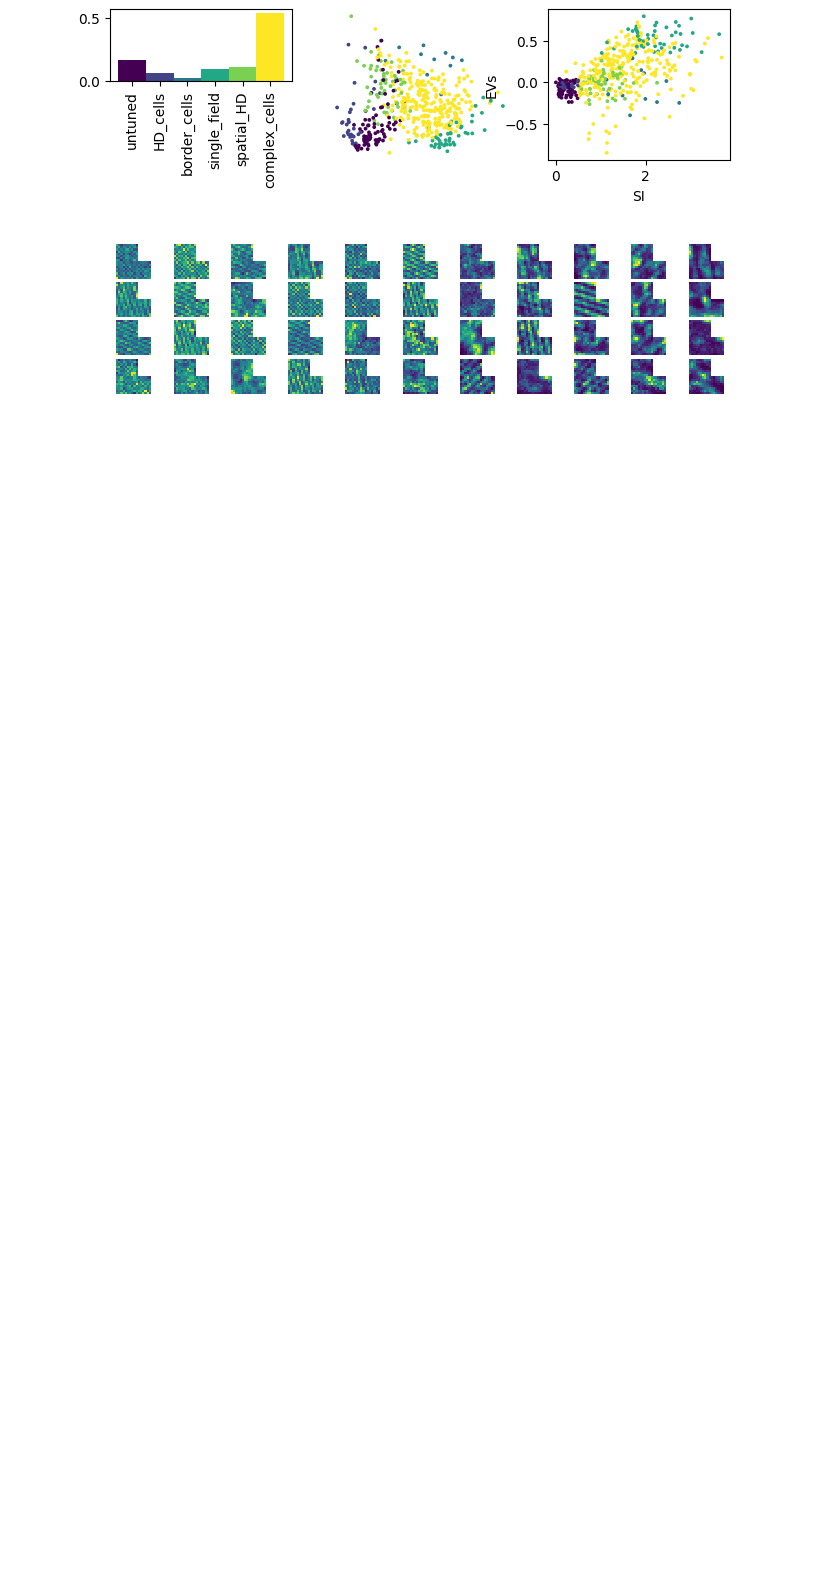

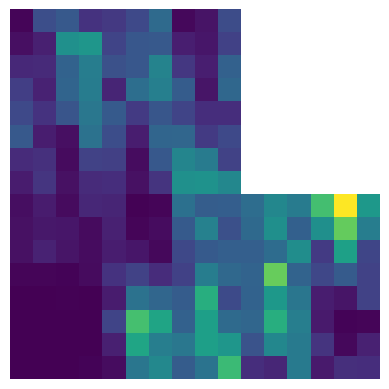

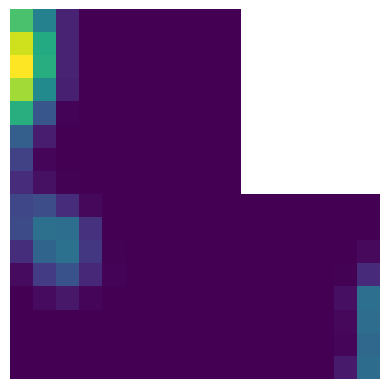

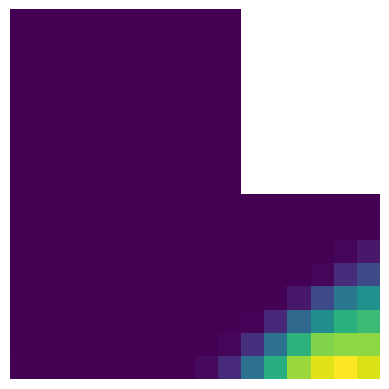

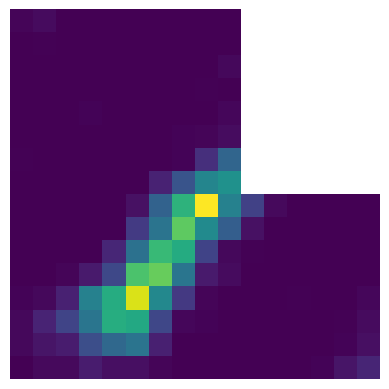

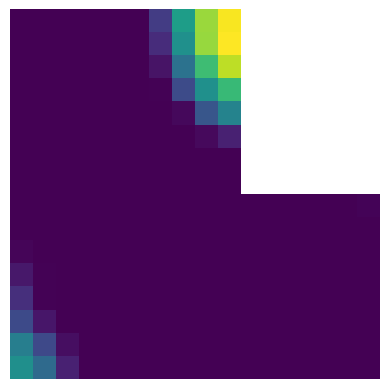

<Figure size 640x480 with 0 Axes>

lognRNN_mask-ContSpeedOnehotHD-s42
Calculating EV_s
Running WAKE


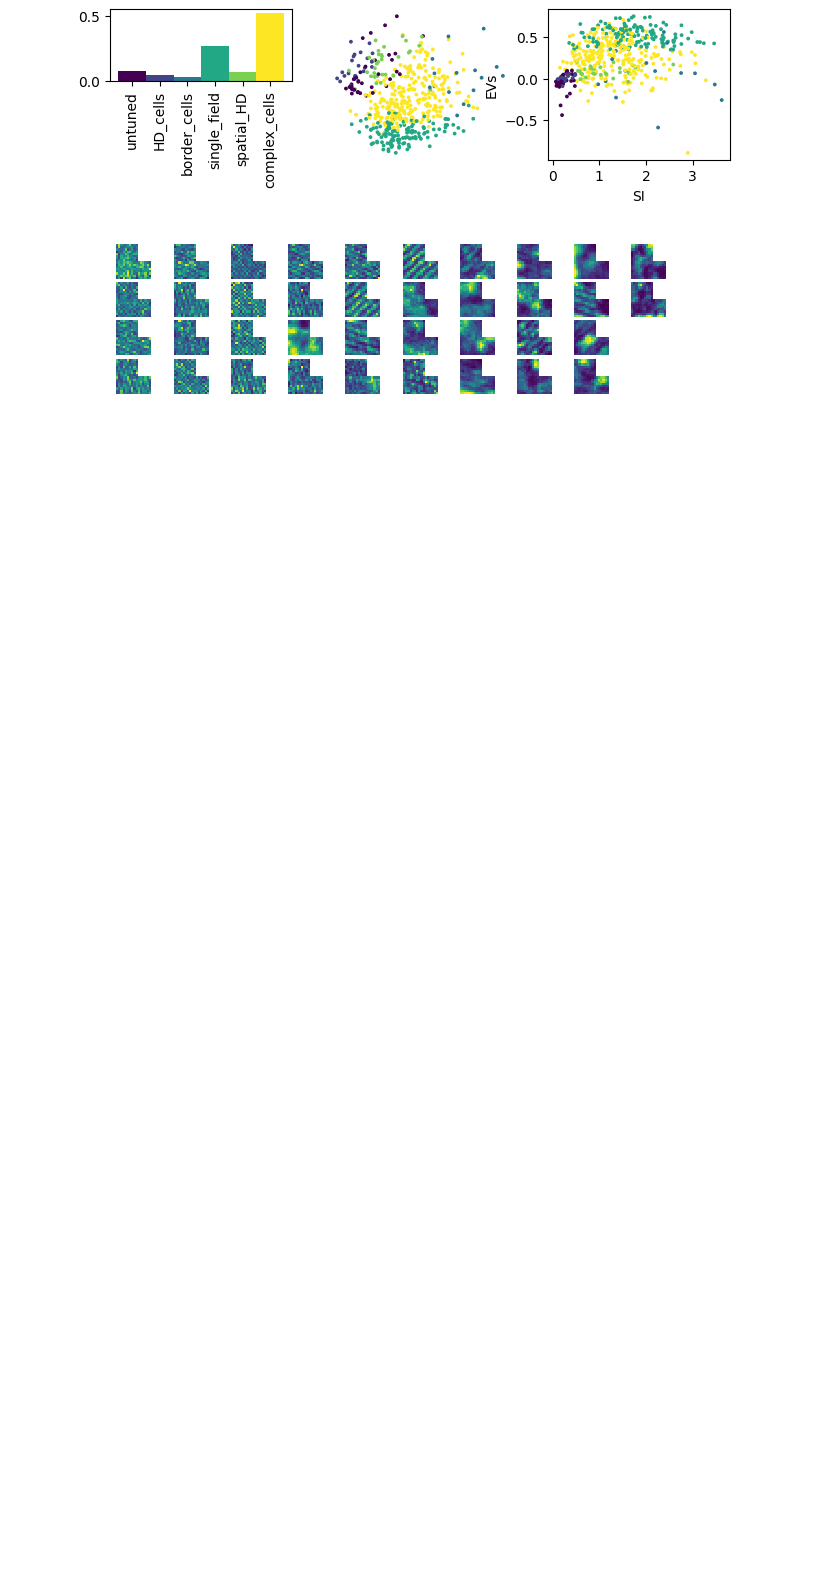

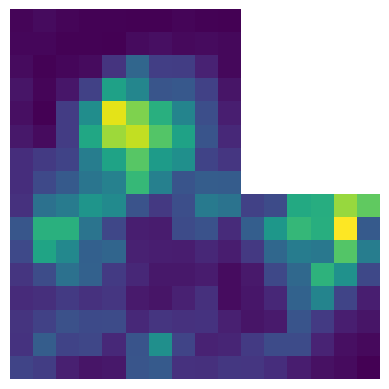

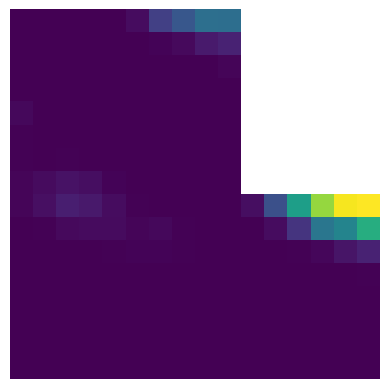

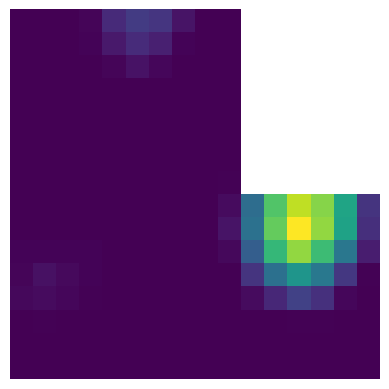

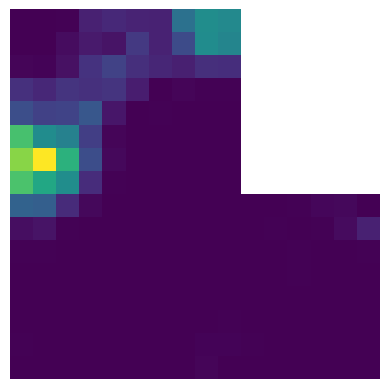

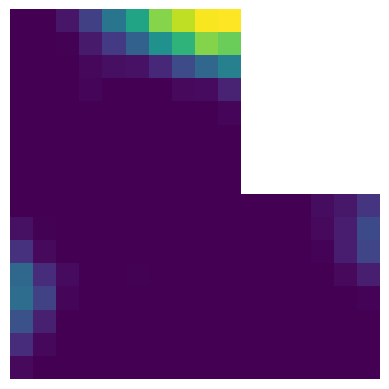

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_1650372/1072874969.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compareFrame[['TCA','groupFrac']] = compareFrame.apply(calculateTCA, axis = 1, result_type="expand")
/tmp/ipykernel_1650372/1072874969.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compareFrame[['TCA','groupFrac']] = compareFrame.apply(calculateTCA, axis = 1, result_type="expand")


In [10]:

def calculateTCA(row):
    predictiveNet = loadNet(row)
    print(row['filename'])
    TCA = TuningCurveAnalysis(predictiveNet, EV_unthresh=0.1, EV_thresh=0.35)
    TCA.cellClassificationFigure()
    plt.show()

    return TCA, TCA.groupFrac

compareFrame[['TCA','groupFrac']] = compareFrame.apply(calculateTCA, axis = 1, result_type="expand")


In [11]:
cellTypeNames = compareFrame.iloc[0].TCA.cellgroups.keys()
fracFrame = compareFrame['groupFrac'].apply(pd.Series)
fracFrame.columns = [i for i in cellTypeNames]

row_names = compareFrame.type
#row_names[row_names==max_msr*10]='Uniform'

fracFrame.index = row_names

fracFrame['untuned'] = -fracFrame['untuned']
fracFrame['HD_cells'] = -fracFrame['HD_cells']

#new_order = ['untuned', 'HD_cells', 'single_field', 'border_cells', 'spatial_HD', 'complex_cells']
#fracFrame = fracFrame.reindex(columns=new_order)


fracFrame

,untuned,HD_cells,border_cells,single_field,spatial_HD,complex_cells
type,,,,,,
thRNN_5win,-0.166,-0.064,0.022,0.094,0.112,0.542
lognRNN_mask,-0.076,-0.042,0.030,0.264,0.066,0.522


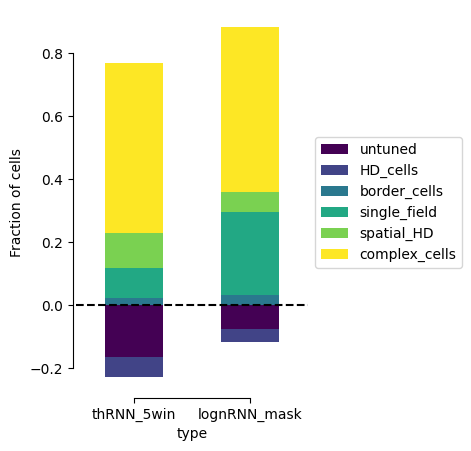

In [12]:
from prnn.utils.plotUtils import setNiceAxes, setPlotDefaults
import seaborn as sns
from prnn.utils.general import saveFig


fig, ax = plt.subplots(figsize=(3, 5))
fracFrame.plot(kind='bar', stacked=True, figsize=(3, 5), colormap='viridis', ax=ax)
ax.plot(ax.get_xlim(), [0,0], 'k--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Fraction of cells')

sns.despine(offset= 2, trim=True) 

saveFig(fig,'CellTypeHists',savefolder,
        filetype='pdf')
plt.show()


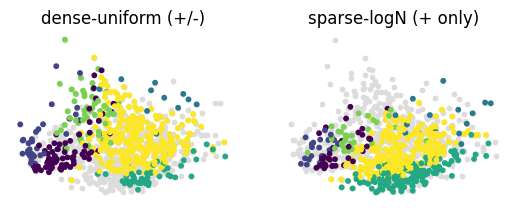

In [13]:
TCA_uniform = compareFrame.iloc[0].TCA
TCA_logN = compareFrame.iloc[1].TCA

from prnn.analysis.TuningCurveAnalysis import FitJointPCA
joint_metrics = FitJointPCA([TCA_uniform,TCA_logN])

names = ['dense-uniform (+/-)','sparse-logN (+ only)']
fig = plt.figure()
for idx,TCA in enumerate([TCA_uniform,TCA_logN]):
    plt.subplot(2,2,idx+1)
    TCA.pcaScatterPanel(color = TCA.groupID,joint=True, s=10)
    plt.title(names[idx])

saveFig(fig,'CellPCAMap',savefolder,
        filetype='pdf')

plt.show()

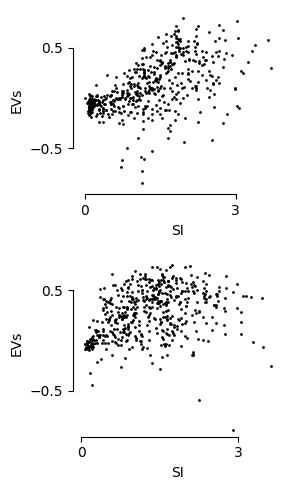

In [14]:
fig = plt.figure(figsize=(3,5))
plt.subplot(2,1,1)
plt.plot(TCA_uniform.metrics['SI'],TCA_uniform.metrics['EVs'],'k.',markersize=2)
plt.xlabel('SI')
plt.ylabel('EVs')
ylims = plt.ylim()
setNiceAxes() 

plt.subplot(2,1,2)
plt.plot(TCA_logN.metrics['SI'],TCA_logN.metrics['EVs'],'k.',markersize=2)
plt.xlabel('SI')
plt.ylabel('EVs')
plt.ylim(ylims)
setNiceAxes() 
plt.tight_layout()

saveFig(fig,'SIEV',savefolder,
        filetype='pdf')

plt.show()

In [42]:
predictiveNet_logN.trainArgs.hiddensize
predictiveNet_logN.trainArgs

Namespace(pRNNtype='lognRNN_mask', hiddensize=800, ntimescale=2.0, trainBias=True, identityInit=False, actenc='SpeedHD', mean_std_ratio=1.0, sparsity=0.05, env='MiniGrid-LRoom-18x18-v0', env_package='gym-minigrid', seqdur=600, numepochs=30, numtrials=1000, batch_size=32, datasetSize=20000, datasetfolder='/home/mila/d/daniel.levenstein/scratch/PredictiveReplay/Data', netsfolder='/home/mila/d/daniel.levenstein/scratch/PredictiveReplay/', savefolder='logNUniform/', loadfolder='', namext='800', contin=False, load_env=-1, saveTrainData=False, seed=14, lr=0.002, bias_lr=0.1, eg_lr=0.002, weight_decay=0.003, eg_weight_decay=1e-08, bptttrunc=100000000.0, dropout=0.15, noisemean=0, noisestd=0.03, f=0.5)

In [45]:
predictiveNet_initLogN = PredictiveNet(predictiveNet_logN.EnvLibrary[0], pRNNtype='lognRNN_rollout', 
                                      dataloader=False, hidden_size=predictiveNet_logN.trainArgs.hiddensize, neuralTimescale=1,
                                      eg_lr=1e-2, mean_std_ratio=predictiveNet_logN.trainArgs.mean_std_ratio, sparsity=predictiveNet_logN.trainArgs.sparsity)
predictiveNet_inituniform = PredictiveNet(predictiveNet_logN.EnvLibrary[0], pRNNtype='thRNN_5win', 
                                      dataloader=False, hidden_size=predictiveNet_logN.trainArgs.hiddensize)


In [ ]:


fig=plt.figure()
plt.subplot(2,2,3)
plt.hist(predictiveNet_initLogN.pRNN.W.detach().numpy().flatten()[:], range=(0, 1), bins=80,density=True, facecolor='k')
plt.xlim([-0.01,0.6])
plt.ylim([0,0.5])
plt.xlabel('Weight')
plt.ylabel('Density')

plt.subplot(4,2,1)
plt.hist(predictiveNet_inituniform.pRNN.W.detach().numpy().flatten()[:], bins=250,density=True, facecolor='k')
plt.xlim([-0.075,0.075])
plt.ylim([0,20])
plt.xlabel('Weight')
plt.ylabel('Density')

plt.subplot(2,2,4)
plt.hist(predictiveNet_logN.pRNN.W.detach().numpy().flatten()[:], range=(0, 1), bins=80,density=True, facecolor='k')
plt.xlim([-0.01,0.6])
plt.ylim([0,0.5])
plt.xlabel('Weight')
plt.ylabel('Density')

plt.subplot(4,2,2)
plt.hist(predictiveNet_uniform.pRNN.W.detach().numpy().flatten()[:], bins=250,density=True, facecolor='k')
plt.xlim([-0.075,0.075])
plt.ylim([0,20])
plt.xlabel('Weight')
plt.ylabel('Density')


plt.tight_layout()

saveFig(fig,'ExHists',savefolder,
        filetype='pdf')
plt.show()

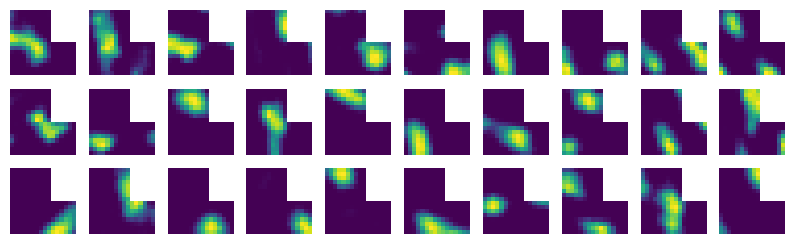

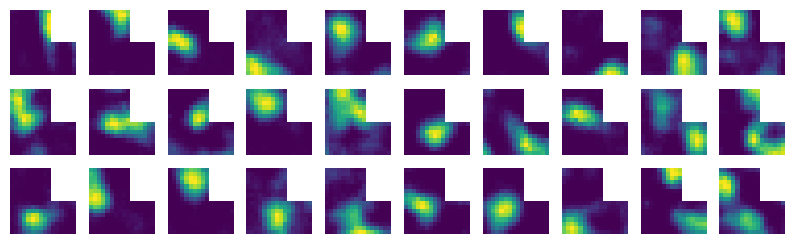

In [14]:

TCA_uniform.cellGroupExamplesFigure(netname='Uniform', savefolder = savefolder,
                                    groupID=TCA_uniform.metrics['EVs']>0.5, 
                                    sortby=TCA_uniform.groupID, dims=[3,10])
TCA_logN.cellGroupExamplesFigure(netname='LogN', savefolder = savefolder,
                                 groupID=TCA_logN.metrics['EVs']>0.5,
                                 sortby=TCA_logN.groupID, dims=[3,10])

Running WAKE
Running SLEEP
Fitting Isomap


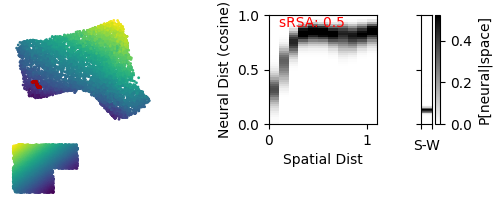

Running WAKE
Running SLEEP
Fitting Isomap


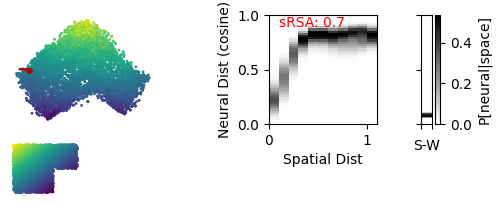

In [17]:
from prnn.analysis.representationalGeometryAnalysis import representationalGeometryAnalysis
from prnn.utils.agent import RatInABoxAgent

agent = RatInABoxAgent('_')
sleepnoise = 0.1
isomap_neighbors = 15
RGA_uniform = representationalGeometryAnalysis(predictiveNet_uniform,noisemag = 0, noisestd=sleepnoise,
                                       actRSA = False,
                                       obsRSA=False,
                                       HDRSA = False,
                                       agent=agent, withIsomap=True, n_neighbors = isomap_neighbors)
RGA_uniform.WakeSleepFigure(None,None)
RGA_logN = representationalGeometryAnalysis(predictiveNet_logN,noisemag = 0, noisestd=sleepnoise,
                                       actRSA = False,
                                       obsRSA=False,
                                       HDRSA = False, 
                                       agent=agent, withIsomap=True, n_neighbors = isomap_neighbors)
RGA_logN.WakeSleepFigure(None,None)

In [48]:
#analysisFrame
grouped_stats = analysisFrame.groupby('type')['dhInf','dx_half'].agg(['mean', 'std'])

/tmp/ipykernel_3201889/3158169203.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_stats = analysisFrame.groupby('type')['dhInf','dx_half'].agg(['mean', 'std'])


/home/mila/d/daniel.levenstein/pRNN/prnn/analysis/representationalGeometryAnalysis.py:836: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t_plot, y_fitted, 'r-', linewidth=2,


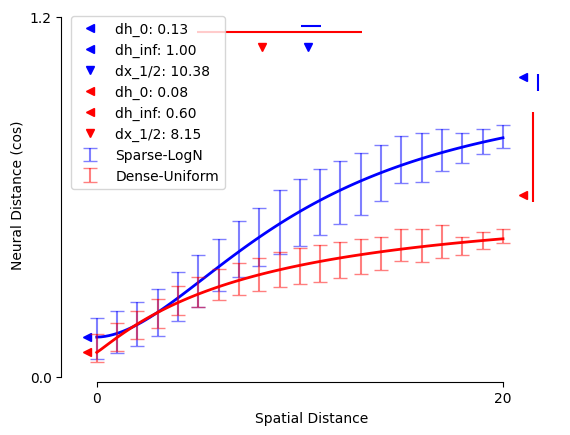

In [57]:

fig = plt.figure()
RGA_logN.hillFitPanel(RGA_logN.hill_fit,color='b',datalabel='Sparse-LogN')
RGA_uniform.hillFitPanel(RGA_uniform.hill_fit,color='r',datalabel='Dense-Uniform')

colors = ['r','b']
for idx,net in enumerate(['thRNN_5win','lognRNN_mask']):
    plt.errorbar(21.5+0.2*idx,grouped_stats['dhInf','mean'][net],
                 yerr=grouped_stats['dhInf','std'][net],
                 fmt='none',color=colors[idx])

    plt.errorbar(grouped_stats['dx_half','mean'][net],1.15+0.02*idx,
                 xerr=grouped_stats['dx_half','std'][net],
                 fmt='none', color=colors[idx])

setNiceAxes()
saveFig(fig,'OrthogGeometry',savefolder,
        filetype='pdf')
        
plt.show()